In [51]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler

#device config
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
df = pd.read_csv("train.csv")
df_train = df.drop("date_time",1)[:5001]
scaler = StandardScaler()
scaler = scaler.fit(df_train)
df_train = scaler.transform(df_train) #df_train is shape 5000,11 and dtype float64

In [3]:
df_train.shape

(5001, 11)

In [4]:
df_train[0:300,:].shape

(300, 11)

In [76]:
#hyperparameters

sequence_length = 50
batch_size = 40
learning_rate = 0.0001
input_size = 11
hidden_size = 32
output_size = 3
num_epochs = 20

In [77]:
#RESHAPING the problem to supervised learning
#X shape --> (length-sequence_length),sequence_length,features 4700,300,11
#y shape --> )length-sequence_length),targets 4700,11

class Train_Time_Series_Dataset(Dataset):
    def __init__(self, complete_data,sequence_length):
        X, y = list(), list()
        for i in range(len(complete_data)):
            end_idx = i + sequence_length
            if end_idx > len(complete_data) - 1:
                break
                
            #seq_x shape --> sequence_length, features (for time steps up to t-1)
            #seq_y shape --> targets (for time step t)
            seq_x, seq_y = complete_data[i:end_idx,:], complete_data[end_idx,8:]
            X.append(seq_x)
            y.append(seq_y)
        X = np.asarray(X, dtype=np.float32)
        y = np.asarray(y, dtype=np.float32)
        
        self.X = torch.from_numpy(X)
        self.y = torch.from_numpy(y)
        self.sequence_length = sequence_length
        self.n_samples = X.shape[0]
        
    def __getitem__(self,index):
        return self.X[index], self.y[index]
        
    def __len__(self):
        return self.n_samples

#Evaluation Dataset returns only features-X and NOT targets-y
class Eval_Dataset(Dataset):
    def __init__(self,sequence):
        sequence = np.asarray(sequence, dtype=np.float32)
        self.X = torch.from_numpy(sequence)
        self.n_samples = sequence.shape[0]
    
    def __getitem__(self, index):
        return self.X[index]

    def __len__(self):
        return self.n_samples

dataset = Train_Time_Series_Dataset(df_train, sequence_length)
train_loader = DataLoader(dataset=dataset,batch_size=batch_size,shuffle=True)
eval_dataset = Eval_Dataset(df_train)  

In [78]:
#testing
dataiter = iter(train_loader)
sample_data =dataiter.next()
#s_features shape --> batch_size, sequence_length, features
#s_targets shape --> batch_size, targets
s_features, s_targets = sample_data
s_features = s_features.to(device)
#s_targets = s_targets.to(device)

In [79]:
#DO NOT CONFUSE Hidden state with Weight matrix!

class RNN(nn.Module):
    def __init__(self,n_features,n_layers,hidden_size,output_size,sequence_length):
        super(RNN,self).__init__()
        self.sequence_length = sequence_length
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(n_features, hidden_size,n_layers,batch_first=True) #expects input of shape --> batch_size, sequence_length, features
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self,x):
        h0 = torch.zeros(self.n_layers,x.size(0),self.hidden_size).to(device) #h0 shape --> n_layers, batch_size, hidden_size
        out, _ = self.rnn(x, h0) #returns hidden states for all t
        out = out[:,-1,:]
        out = self.fc(out) #out shape --> batch_size, output_size
        return out
    
    def predict(self,known_sequence, future_sequence):
        model.eval()
        #known_sequence shape --> 
        #x = complete_sequence[starting_point-sequence_length:starting_point] #x data
        
        known_sequence = known_sequence.to(device)
        future_sequence = future_sequence.to(device)
        
        x = known_sequence[-self.sequence_length:]
        x = torch.reshape(x,(1,-1,11)) #x shape --> batch_size, sequence_length, features = 1, 30, 11
        
        outputs = []
        
        for i in range(len(future_sequence)): #future_sequence shape --> future_sequence_length, features
            h0 = torch.zeros(self.n_layers,1,self.hidden_size).to(device)
            out, _ = self.rnn(x, h0)
            out = out[:,-1,:] #out shape --> 1,hidden_size
            out = self.fc(out) #out shape --> 1,3
            out = out[0]
            
            outputs.append(out)
            
            new_x = future_sequence[i,:8]
            
            new_t = torch.cat((new_x,out),-1) #creating the new data point by concatenating the 8 known features with 3 predicted
            x = torch.roll(x,-1,1) #shifting the elements in the tensor by -1 (the first element becomes last)
            x[0,-1] = new_t #overwriting the last element
    
        return outputs
    
model = RNN(input_size,3,hidden_size,output_size,sequence_length).to(device)
#loss and Optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [80]:
x=eval_dataset[470:500]
new_x = x[0,:8].to(device)
#x=torch.reshape(x,(1,-1,11)).to(device)
#x=torch.roll(x,-1,1)
#x[:,-1]=new_t
outs = model(s_features)
#outs = torch.reshape(outs,(1,40,3))
out = outs[1]
out.shape
new_x.shape
new_t = torch.cat((new_x,out),-1)
print(out)
print(new_x)
print(new_t)

tensor([-0.0683,  0.1934, -0.2087], device='cuda:0', grad_fn=<SelectBackward>)
tensor([-1.2352, -0.3742, -1.6134,  2.8256,  1.7554, -0.8828,  1.4914,  2.3536],
       device='cuda:0')
tensor([-1.2352, -0.3742, -1.6134,  2.8256,  1.7554, -0.8828,  1.4914,  2.3536,
        -0.0683,  0.1934, -0.2087], device='cuda:0', grad_fn=<CatBackward>)


In [81]:
#training loop
n_total_steps = len(train_loader)

running_loss = 0.0
running_correct = 0

#TRAIN
for epoch in range(num_epochs):
    for i, (features,targets) in enumerate(train_loader): #enumerate DataLoader
        #features shape --> batch_size, sequence_length, features
        #targets shape --> batch_size, targets
        features = features.to(device)
        targets = targets.to(device)
        
        #forward
        outputs = model(features)
        loss = criterion(outputs, targets)

        #backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss+= loss.item() #item returns a number

        if (i+1) % 30 == 0:
            print(f'epoch {epoch+1} / {num_epochs}, step {i+1} / {n_total_steps}, loss = {loss.item()}')
            running_loss = 0.0


#torch.save(model.state_dict(),"mymodel.pth")

s_features = s_features.to(device)
output = model(s_features)
print(s_features.shape)

epoch 1 / 20, step 30 / 124, loss = 1.0029394626617432
epoch 1 / 20, step 60 / 124, loss = 0.9326061606407166
epoch 1 / 20, step 90 / 124, loss = 1.0138275623321533
epoch 1 / 20, step 120 / 124, loss = 1.3498902320861816
epoch 2 / 20, step 30 / 124, loss = 0.6564900279045105
epoch 2 / 20, step 60 / 124, loss = 0.38668927550315857
epoch 2 / 20, step 90 / 124, loss = 0.3062513470649719
epoch 2 / 20, step 120 / 124, loss = 0.5222509503364563
epoch 3 / 20, step 30 / 124, loss = 0.5333806872367859
epoch 3 / 20, step 60 / 124, loss = 0.7038375735282898
epoch 3 / 20, step 90 / 124, loss = 0.2677261531352997
epoch 3 / 20, step 120 / 124, loss = 0.24601127207279205
epoch 4 / 20, step 30 / 124, loss = 0.24771548807621002
epoch 4 / 20, step 60 / 124, loss = 0.5751368403434753
epoch 4 / 20, step 90 / 124, loss = 0.37224438786506653
epoch 4 / 20, step 120 / 124, loss = 0.45664161443710327
epoch 5 / 20, step 30 / 124, loss = 0.23442962765693665
epoch 5 / 20, step 60 / 124, loss = 0.3739376962184906


tensor([[ 0.6611,  0.1662,  0.2620],
        [ 0.9855,  0.4692,  0.5338],
        [ 0.3366,  0.0796,  0.0751],
        [ 0.4177,  0.3249, -0.1523],
        [ 0.8233,  0.3537, -0.2259]])


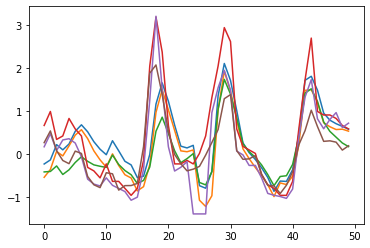

In [83]:
#test
test_outputs = torch.stack(model.predict(eval_dataset[400:500],eval_dataset[500:550])).cpu().detach().numpy()
evv = eval_dataset[500:550,8:]
print(evv[:5])
#.cpu().detach().numpy()
plt.plot(test_outputs)
plt.plot(evv)
plt.show()

In [42]:
g= eval_dataset[500:550]
g[1,:8]

tensor([-1.0340,  1.0353, -0.4017,  1.4142,  0.3736, -0.5223,  0.8259,  0.5027])